# Algorithmic Fairness in Practice

Now that we've discussed algorithmic fairness and bias, let's work through a real example and see how an algorithm can be biased.

In May 2016, Jeff Larson and others from ProPublica published a story about [algorithmic bias in criminal justice risk assessment scores](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). These scores are used to inform decisions about who can be set free at every stage of the criminal justice system, from assigning bond amounts to even more fundamental decisions about defendants’ freedom. In Arizona, Colorado, Delaware, Kentucky, Louisiana, Oklahoma, Virginia, Washington and Wisconsin, the results of such assessments are given to judges during criminal sentencing.

In 2014, then U.S. Attorney General Eric Holder warned that the risk scores might be injecting bias into the courts. He called for the U.S. Sentencing Commission to study their use. "Although these measures were crafted with the best of intentions, I am concerned that they inadvertently undermine our efforts to ensure individualized and equal justice," he said, adding, "they may exacerbate unwarranted and unjust disparities that are already far too common in our criminal justice system and in our society." The sentencing commission did not, however, launch a study of risk scores. So, ProPublica did, as part of a larger examination of the powerful, largely hidden effect of algorithms in American life.

ProPublica obtained the risk scores assigned to more than 7,000 people arrested in Broward County, Florida, in 2013 and 2014 and checked to see how many were charged with new crimes over the next two years. The score proved remarkably unreliable in forecasting violent crime. In addition, ProPublica was able to show the algorithm was racially biased. 

ProPublica completed a thorough analysis involving logistic regression, survival analysis and other statistical methods ([check out more details here if interested](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/)), but here we will be exploring how the algorithm is biased and communicating this bias. 

The data for ProPublica's analysis is contained in the file `compas-scores-two-years.csv`. Below are the variables we will be using:

* `race`: Race of the individual (we will only focus on `African-American` and `Caucasian` race categories).
* `two_year_recid`: Indicator if the individual reoffended (commited another crime) within 2 years.
* `decile_score`: Risk score, 1-10, 1 being low and 10 being high.
* `score_text`: score group, "Low": `decile_score` = 1-3, "Medium": `decile_score` = 4-7, "High": `decile_score` = 8-10.

### Question 1
While there are several race/ethnicity categories represented in this dataset, we will limit our analyses to those who self-identified as Caucasian or African-American. Read in the data and filter the data frame to only include Caucasian and African-American individuals. How many African-American individuals are represented in this dataset and how many Caucasian individuals are represented?

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

In [63]:
scores = pd.read_csv("compas-scores-two-years.csv", index_col = False)
scores.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [64]:
races = ["African-American", "Caucasian"]
data = data[data.race.isin(races)]
data["race"].value_counts()

African-American    3696
Caucasian           2454
Name: race, dtype: int64

There are 3,696 African-Americans and 2,454 Caucasians.

### Question 2
Make 2 bar charts of `decile_score`, one for each race group. What do you notice about the distributions of scores for the two groups?

In [65]:
count_series = data.groupby(['race', 'decile_score']).size()
new_df = count_series.to_frame(name = 'count').reset_index()
new_df.head()

,race,decile_score,count
0,African-American,1,398
1,African-American,2,393
2,African-American,3,346
3,African-American,4,385
4,African-American,5,365


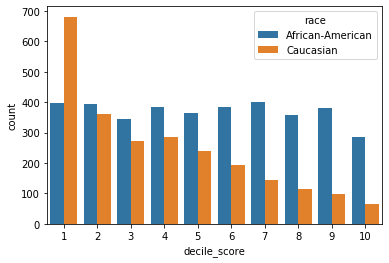

In [66]:
sns.barplot(data = new_df , x = 'decile_score', y = 'count', hue = 'race', ci = None)

The scores are right-skewed for Caucasians and uniformly distributed for African-Americans. In other words, most Caucasians have lower risk scores (the number of individuals in each risk score decreases as score increases) while the number of African-Americans in each score group are about equal. 

### Question 3
Is the risk score a good predictor of two-year recidivism (i.e., committing another crime within 2 years)? Create a new variable called `binary_score` that is equal to 0 if `score_text` is equal to "Low" (this will be the "low-risk" group) and 1 otherwise (this will be the "high-risk" group). Create a 2x2 table of `binary_score` and `two_year_recid` using the `table` function. Calculate accuracy, sensitivity, specificity, false positive rate and false negative rate by hand. What is the accuracy? Are the sensitivity and specificity balanced? Are the false positive rate and false negative rate balanced?  

* Here, false positive rate is the number of false positives over the total number of true negatives, and false negative rate is the number of false negatives over the total number of true positives.

In [67]:
data['binary_score'] = 1
data.loc[(data['score_text'] == "Low"), 'binary_score'] = 0

pd.crosstab(data['two_year_recid'], data['binary_score'], rownames=['binary_score'], colnames=['two_year_recid'])

two_year_recid,0,1
binary_score,,
0,2129,1154
1,993,1874


In [68]:
n = 1874 + 2129 + 993 + 1154
acc = (1874 + 2129)/n

TP = 1874
FP = 993
TN = 2129
FN = 1154

sens = TP/(TP+FN)
spec = TN/(TN+FP)
FP_rate = FP/(FP+TN)
FN_rate = FN/(FN+TP)

print("Accuracy = " + str(acc))
print("Sensitivity = " + str(sens))
print("Specificity = " + str(spec))
print("FP Rate = " + str(FP_rate))
print("FN Rate = " + str(FN_rate))

Accuracy = 0.6508943089430894
Sensitivity = 0.6188903566710701
Specificity = 0.6819346572709801
FP Rate = 0.3180653427290199
FN Rate = 0.38110964332893


The overall accuracy is 65% - not much better than flipping a coin. The sensitivity and specificity are balanced. This means the scoring algorithm is equally as good at correctly classifying someone as high-risk who subsequently reoffends within two years, as correctly classifying someone as low-risk who subsequently does not reoffend within two years. The false positive rate and false negative rate are also balanced.

### Question 4
Now calculate the accuracy, sensitivity, specificity, false positive rate and false negative rate for each race group. Does the algorithm perform better for one group over the other? Describe how the model is biased. 

* Hint: think about what false positives, false negatives, false positive rate and false negative rate mean in this context.

In [69]:
df_a = data[data['race'] == "African-American"]
pd.crosstab(df_a['two_year_recid'], df_a['binary_score'], rownames=['binary_score'], colnames=['two_year_recid'])

two_year_recid,0,1
binary_score,,
0,990,805
1,532,1369


In [71]:
n = 990 + 805 + 532 + 1369
acc = (990 + 1369)/n

TP = 1369
FP = 805
TN = 990
FN = 532

sens = TP/(TP+FN)
spec = TN/(TN+FP)
FP_rate = FP/(FP+TN)
FN_rate = FN/(FN+TP)

print("Accuracy = " + str(acc))
print("Sensitivity = " + str(sens))
print("Specificity = " + str(spec))
print("FP Rate = " + str(FP_rate))
print("FN Rate = " + str(FN_rate))

Accuracy = 0.6382575757575758
Sensitivity = 0.7201472908995266
Specificity = 0.5515320334261838
FP Rate = 0.44846796657381616
FN Rate = 0.27985270910047344


In [72]:
df_c = data[data['race'] == "Caucasian"]
pd.crosstab(df_c['two_year_recid'], df_c['binary_score'], rownames=['binary_score'], colnames=['two_year_recid'])

two_year_recid,0,1
binary_score,,
0,1139,349
1,461,505


In [74]:
n = 1139 + 349 + 461 + 505
acc = (1139 + 505)/n

TP = 505
FP = 349
TN = 1139
FN = 461

sens = TP/(TP+FN)
spec = TN/(TN+FP)
FP_rate = FP/(FP+TN)
FN_rate = FN/(FN+TP)

print("Accuracy = " + str(acc))
print("Sensitivity = " + str(sens))
print("Specificity = " + str(spec))
print("FP Rate = " + str(FP_rate))
print("FN Rate = " + str(FN_rate))

Accuracy = 0.6699266503667481
Sensitivity = 0.5227743271221532
Specificity = 0.7654569892473119
FP Rate = 0.23454301075268819
FN Rate = 0.4772256728778468


These contingency tables reveal that the algorithm is more likely to misclassify an African-American defendant as higher risk than a Caucasian defendant. African-American defendants who do not recidivate were nearly twice as likely to be classified as higher risk compared to their Caucasian counterparts (45 percent vs. 23 percent).

The algorithm tended to make the opposite mistake with Caucasians, meaning that it was more likely to wrongly predict that Caucasian people would not commit additional crimes if released compared to African-American defendants. The algorithm under-classified Caucasian reoffenders as low risk 70.5 percent more often than African-American reoffenders (48 percent vs. 28 percent).